<a href="https://colab.research.google.com/github/bellaabdelouahab/Library-Python/blob/main/minilastUntitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
files.upload() #upload kaggle.json
! pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions -h
!kaggle competitions download -c DATASET
!pip install librosa

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=681708adf282ad637ee809688307462f5367539f5fc0341185b07ce13b20f3a4
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
kaggle.json
usage: kaggle competitions [-h]
                           {list,files,download,submit,submissions,leaderboard}
                           ...

optional arguments:
  -h, --help            show this help message and exit

commands:
  {list,files,download,submit,submissions,leaderboard}
    list                List available competitions
    files               List competition files
    download            Download competition files
    submit             

In [4]:
!kaggle datasets download -d ogechukwu/voice

 99% 793M/802M [00:07<00:00, 145MB/s]
100% 802M/802M [00:07<00:00, 109MB/s]


In [5]:
!ls

kaggle.json  sample_data  voice.zip


In [6]:
!mkdir Voice
!unzip voice.zip -d Voice

Archive:  voice.zip
  inflating: Voice/BVC_Voice_Bio_Public.xlsx  
  inflating: Voice/BVCvoicereadme.txt  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VE1.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VE2.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VE3.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VE4.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VE5.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VV1.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VV2.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VV3.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VV4.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4001_VV5.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4008_VE1.wav  
  inflating: Voice/S_02_voice/S_02/multiple_sentences/S_02_4008_VE2.wav  
  inf

In [7]:
# Voice/multiple_sentences/multiple_sentences
!ls Voice

BVC_Voice_Bio_Public.xlsx  multiple_sentences  S_02_voice
BVCvoicereadme.txt	   one_sentence


In [3]:
# imports 
import numpy as np
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [13]:
#this function takes an numpy audio and return the spectral properties below
def spectral_properties(y: np.ndarray, fs: int) -> dict:
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1/fs)
    spec = np.abs(spec)
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    sd = np.sqrt(np.sum(amp * ((freq - mean) ** 2)))
    amp_cumsum = np.cumsum(amp)
    median = freq[len(amp_cumsum[amp_cumsum <= 0.5]) + 1]
    mode = freq[amp.argmax()]
    Q25 = freq[len(amp_cumsum[amp_cumsum <= 0.25]) + 1]
    Q75 = freq[len(amp_cumsum[amp_cumsum <= 0.75]) + 1]
    IQR = Q75/1000 - Q25/1000
    z = amp - amp.mean()
    w = amp.std()
    skew = ((z ** 3).sum() / (len(spec) - 1)) / w ** 3
    kurt = ((z ** 4).sum() / (len(spec) - 1)) / w ** 4
    result_d = {
        'meanfreq': mean/1000,
        'sd': sd/1000,
        'median': median/1000,
        'mode': mode/1000,
        'Q25': Q25/1000,
        'Q75': Q75/1000,
        'IQR': IQR,
        'skew': skew,
        'kurt': kurt/1000,
    }
    return result_d

In [10]:
m_files = os.listdir("Voice/multiple_sentences/multiple_sentences")
print(len(m_files))

1778


In [ ]:
import librosa
from IPython.display import clear_output
mydata = []
for i in range(len(m_files)):
  clear_output(wait=True)
  print(round(i*100/len(m_files),2),"%")
  Data, fs = librosa.load('Voice/multiple_sentences/multiple_sentences/'+m_files[i])
  mydata.append(list(spectral_properties(Data,fs).values())+[m_files[i][5:9]])

In [19]:
df = pd.read_excel("Voice/BVC_Voice_Bio_Public.xlsx")
df.head()

,New_ID,Sex,Age,Ethnicity,Unnamed: 4,Unnamed: 5
0,4001,'Male',19,'Igbo',NaN,336
1,4002,'Male',23,'Igbo',NaN,190
2,4003,'Female',18,'Ikwerre',NaN,NaN
3,4004,'Male',23,'Annang',NaN,% Actual subjects = 526
4,4005,'Female',17,'Igbo',NaN,% Male subjects = 336


In [20]:
new_data = []
for i in range(len(mydata)):
  for j in range(len(df["New_ID"])):
    if str(df["New_ID"][j]) == mydata[i][9]:
      new_data.append(mydata[i][:9]+[df["Sex"][j]])
print(new_data[0])

[1.9179826520758214, 2.1215057332087777, 0.9864109996866186, 0.16584142901911628, 0.4085572704481354, 2.8357156847383265, 2.427158414290191, 8.489143765599994, 0.11754416102899429, "'Female'"]


In [ ]:
df1 = pd.DataFrame(new_data,columns =['meanfreq','sd','median','mode','Q25','Q75','IQR','skew','kurt','Label'])
df1.head()

In [22]:
df1["Label"].value_counts()

'Female'    1068
'Male'       710
Name: Label, dtype: int64

In [23]:
df1.to_excel("gendervoice.xlsx")

In [1]:
def NormalizeData(Data,Max,Min):
  return (Data - Min )/ (Max - Min)

In [4]:
VoiceDataSet = pd.read_excel("gendervoice.xlsx")
VoiceDataSet.head()

,Unnamed: 0,meanfreq,sd,median,mode,Q25,Q75,IQR,skew,kurt,Label
0,0,1.917983,2.121506,0.986411,0.165841,0.408557,2.835716,2.427158,8.489144,0.117544,'Female'
1,1,1.778731,2.405135,0.598568,0.551891,0.373419,2.209393,1.835975,6.086124,0.049044,'Female'
2,2,1.663124,1.790090,1.169365,0.461686,0.463740,2.010054,1.546314,5.453529,0.044811,'Female'
3,3,1.646969,2.147702,0.718801,0.410352,0.410352,1.918630,1.508278,10.804550,0.172210,'Female'
4,4,2.013166,2.848938,0.338859,0.312019,0.272429,2.983973,2.711544,10.247434,0.132691,'Female'


In [5]:
VoiceDataSet = VoiceDataSet.drop(['Unnamed: 0'], axis=1)

#nbr of clumns
print(VoiceDataSet.columns)

# Values shape
print(VoiceDataSet.shape)

# counting values male and female
print(VoiceDataSet["Label"].value_counts())

Index(['meanfreq', 'sd', 'median', 'mode', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'Label'],
      dtype='object')
(1000, 10)
'Female'    613
'Male'      387
Name: Label, dtype: int64


In [6]:
# cut data 
VoiceDataSet=VoiceDataSet.sort_values(by=['Label'])
VoiceDataSet = VoiceDataSet[358:]

In [7]:
#extract attributes
X_ = VoiceDataSet.drop(['Label'], axis=1)
X_.head()

,meanfreq,sd,median,mode,Q25,Q75,IQR,skew,kurt
785,2.962405,3.524978,0.711946,0.000000,0.242560,5.955827,5.713267,7.908556,0.084017
788,1.642391,2.029580,0.685336,0.267961,0.336705,2.400429,2.063724,6.263713,0.049755
789,1.326675,1.898056,0.600822,0.201803,0.253782,1.428671,1.174889,6.803917,0.062821
790,1.502932,1.991963,0.580551,0.194201,0.375409,1.706779,1.331370,8.083067,0.081010
791,1.518598,1.598017,0.981201,0.257122,0.483845,1.841229,1.357384,5.722334,0.048162


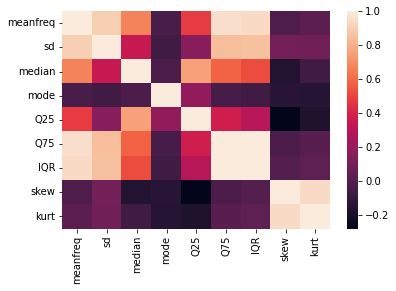

In [8]:
# show the Relations between attributes
correlation = X_.corr()
sns.heatmap(correlation)
plt.show()

In [21]:
#extract Labels
Y_ = VoiceDataSet['Label']

# splet data
X_train , X_test , y_train , y_test = train_test_split(X_,Y_, test_size=0.3)

#initulize random forest model
Model = RandomForestClassifier(random_state=1)
# from sklearn.model_selection import cross_val_score
# scores = cross_val_score(Model, X_,Y_, cv=10)
Model.fit(X_train,y_train)
# scores
# print(Model.score(X_test,y_test))

RandomForestClassifier(random_state=1)

In [29]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(Model, open(filename, 'wb'))

In [ ]:
# load the model from disk
filename = 'finalized_model.sav'
Model = pickle.load(open(filename, 'rb'))

In [52]:
# prosses data
import librosa
audioFilename = "woman.wav"
Data, fs = librosa.load(audioFilename)
prp = spectral_properties(Data,fs)
Xpred = pd.DataFrame(prp,index=[0])
Xpred.head()

,meanfreq,sd,median,mode,Q25,Q75,IQR,skew,kurt
0,1.808968,2.188947,0.636087,0.275873,0.286289,2.489576,2.203286,14.506483,0.300931


In [53]:
import IPython
IPython.display.Audio(audioFilename)

In [54]:
Model.predict(Xpred)

array(["'Female'"], dtype=object)